In [1]:
!pip3 install pymc3==3.9.3
!pip3 install arviz==0.11.0
!pip3 install pymc
!pip3 install statsmodels

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import seaborn as sns
import arviz as az
from statsmodels.tsa import stattools
import statsmodels.api as sm
import pymc3 as pm
import pymc

import os
import sys
from plot_lib import set_default

set_default(figsize=(6, 4))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Dataset

The badhealth dataset is from a German health survey in the year 1998. It records the number of visits to doctors during the year 1998 for $1127$ patients. 

In [3]:
!wget https://www.key2stats.com/badhealth_180_63.csv -O badhealth.csv

--2021-04-27 18:48:26--  https://www.key2stats.com/badhealth_180_63.csv
Resolving www.key2stats.com (www.key2stats.com)... 52.207.128.24
Connecting to www.key2stats.com (www.key2stats.com)|52.207.128.24|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20412 (20K) [application/csv]
Saving to: ‘badhealth.csv’

badhealth.csv       100%[===================>]  19.93K  --.-KB/s    in 0.09s   

2021-04-27 18:48:26 (232 KB/s) - ‘badhealth.csv’ saved [20412/20412]



In [4]:
# Read dataset - Urine
badhealth = pd.read_csv('badhealth.csv')
# Checking dataframe
print("The shape of the dataset is: {}".format(badhealth.shape))
badhealth.head()

The shape of the dataset is: (1127, 5)


,Unnamed: 0,X,numvisit,badh,age
0,1,1,30,0,58
1,2,2,20,0,54
2,3,3,16,0,44
3,4,4,20,0,57
4,5,5,15,0,33


In [5]:
# Describing dataset and looking for NaN
print(badhealth.isnull().values.any())
badhealth.describe()
badhealth.pop('Unnamed: 0')
badhealth.pop('X')
badhealth.describe()

False


,numvisit,badh,age
count,1127.000000,1127.000000,1127.000000
mean,2.353150,0.099379,37.228926
std,3.461466,0.299303,10.828919
min,0.000000,0.000000,20.000000
25%,0.000000,0.000000,28.000000
50%,1.000000,0.000000,35.000000
75%,3.000000,0.000000,46.000000
max,40.000000,1.000000,60.000000


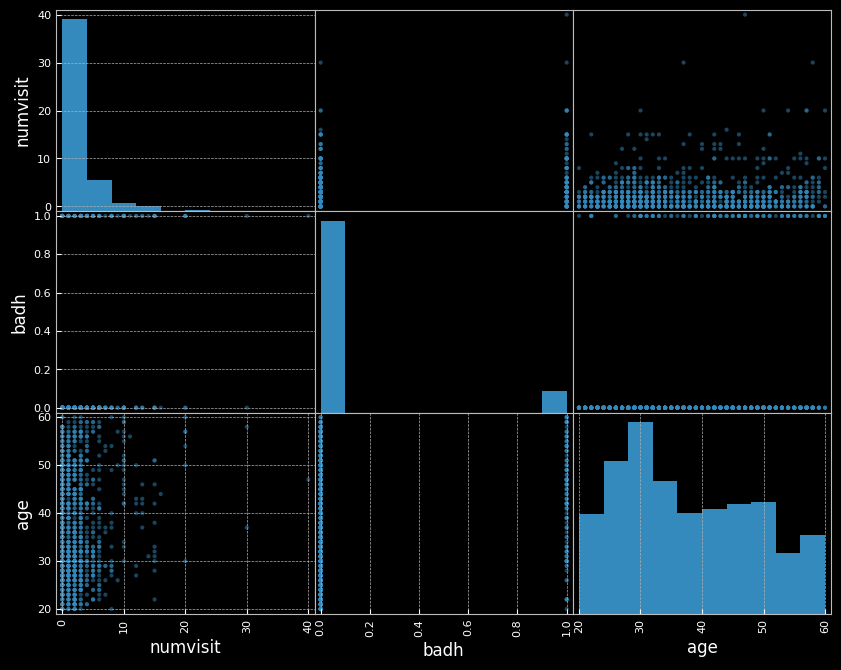

In [6]:
# Showing scatter matrix
plt.rc('figure', figsize=(10, 8), dpi=100)
pd.plotting.scatter_matrix(badhealth, alpha=0.5)
plt.show()
# Get back to defaults
set_default(figsize=(6, 4))

Plotting histogram of number of visits.

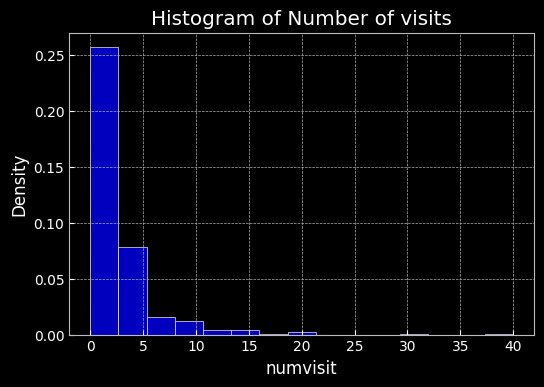

In [7]:
# Plotting the histogram of infant
fig, ax = plt.subplots(1, 1)
sns.histplot(badhealth['numvisit'], stat= 'density', bins = 15)
plt.title('Histogram of Number of visits')
plt.show()

Our two covariants which we'll use as explanatory variables are `badh`, which gives us an indicator variable for whether the patient claims to be in bad health or not.
As well as the `patient's age`. 

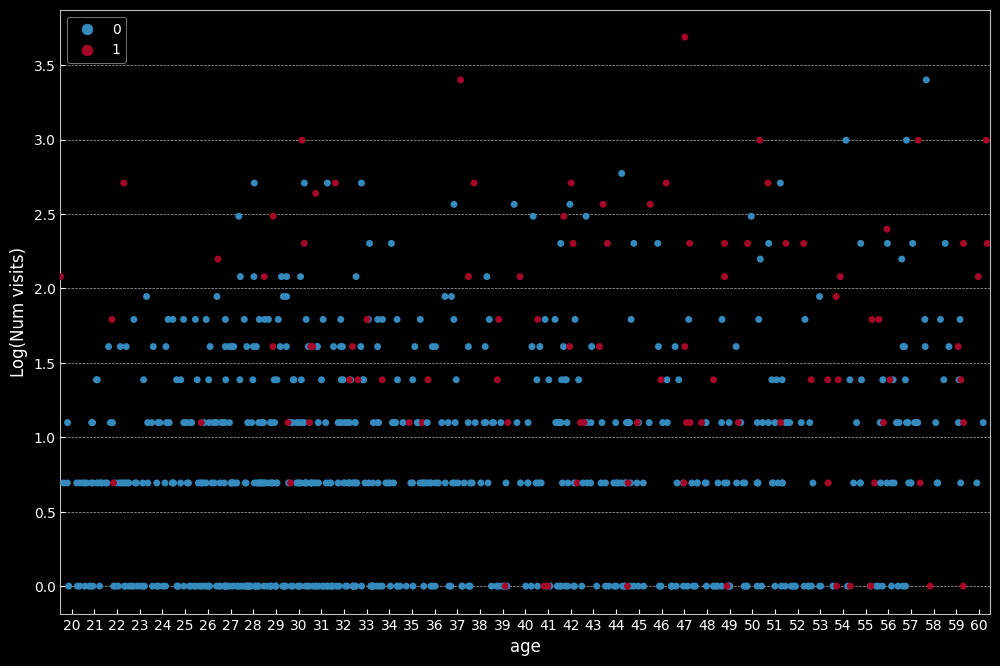

The count of unique values in numvisit are: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 20 30 40]


In [8]:
plt.figure(figsize=(12, 8))
sns.stripplot(x=badhealth['age'], y = np.log(badhealth['numvisit']), hue = badhealth['badh'], jitter=0.5)
#plt.scatter(badhealth['numvisit'], np.log(badhealth['badh']), c='red', zorder=10, label='Data')
plt.xlabel('age')
plt.ylabel('Log(Num visits)')
plt.legend(loc='upper left')
plt.show()

print('The count of unique values in numvisit are: {}'.format(np.unique(badhealth['numvisit'])))

In [9]:
### Formatting data as numpy instead of DF
Y = badhealth.pop('numvisit').to_numpy()
X = badhealth.to_numpy()

As age increases the number of doctor visits increases having good health. Additionally, it looks like being in bad health, not surprisingly, is associated with more visits to the doctor.  

### Model

It appears that both age and bad health are related to the number of doctor visits. We should include model terms for both variables. If we believe the age/visits relationship is different between healthy and non-healthy populations, we should also include an interaction term.  But this is not gonna be done here.

We already saw one drawback of taking the log of the number of visits as our response variable. You can't take the log of 0. So, in order to be able to model it, while keeping all the individuals who never visited the doctor. We would have to add a number maybe a small number like $0.1$ to the response before taking the log. 

Instead of using logged number of visits as our response variable, let's instead choose the Poisson linear model. One major advantage of the Poisson linear model is that the log transformation appears in the link function. We are taking the log of the mean rather than the response itself. 

Recall that for a Poisson regression, the model should be (in this particular case)

$y_i | \phi_i \stackrel{ind}{\sim} Poisson(\lambda_i)$

$ \lambda_i \rightarrow \text{Count of events} $

$ log(\lambda_i) = \beta_0 + \beta_1 X_{1,i} + \beta_2 X_{2,i} + \beta_3 X_{1,i} X_{2,i}$

$\mathbb{E}(\lambda_i) = \lambda_i = exp^{\beta_0 + \beta_1 X_{1,i} + \beta_2 X_{2,i} + \beta_3 X_{1,i} X_{2,i}}$

$\beta_1, ..., \beta_3 \sim \text{Normal}(0, 1e^4)$

$\beta_0 \sim \mathcal{N}(0, 1e^6)$

In [10]:
with pm.Model() as lr:
    # Definen priors of parameters
    b_0 = pm.Normal('intercept', 0, 1e6) # Non informative prior for intercept
    ### We need 6 parameters, therefore, 6 "slopes"
    b_1 = pm.Normal('b_badh', mu = 0.0, sigma = 1e4) # Bad health coefficient
    b_2 = pm.Normal('b_age', mu = 0.0, sigma = 1e4) # Age coefficient
    b_3 = pm.Normal('b_intx', mu = 0.0, sigma = 1e4) # Interaction coefficient age * bhealth
    
    x_ = pm.Data('features', X) # a data container, can be changed

    lamb = pm.math.exp(b_0 + b_1 * x_[:, 0] + b_2 * x_[:, 1] + b_3 * x_[:, 0] * x_[:, 1])

    # Likelihood
    obs = pm.Poisson('likelihood', mu = lamb, observed = Y)

In [11]:
with lr:
    # Use MCMC to sample 10000 samples
    trace = pm.sample(3000, tune = 1000, cores=4, init='adapt_diag')
    # Tune gives a number of samples to reject. These are used to calibrate the sampler. 
    # After the number of samples in tune, the following are considered useful.

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_intx, b_age, b_badh, intercept]


Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 54 seconds.
The acceptance probability does not match the target. It is 0.8982232579835229, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.887089658306657, but should be close to 0.8. Try to increase the number of tuning steps.


### MCMC convergence diagnostic


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


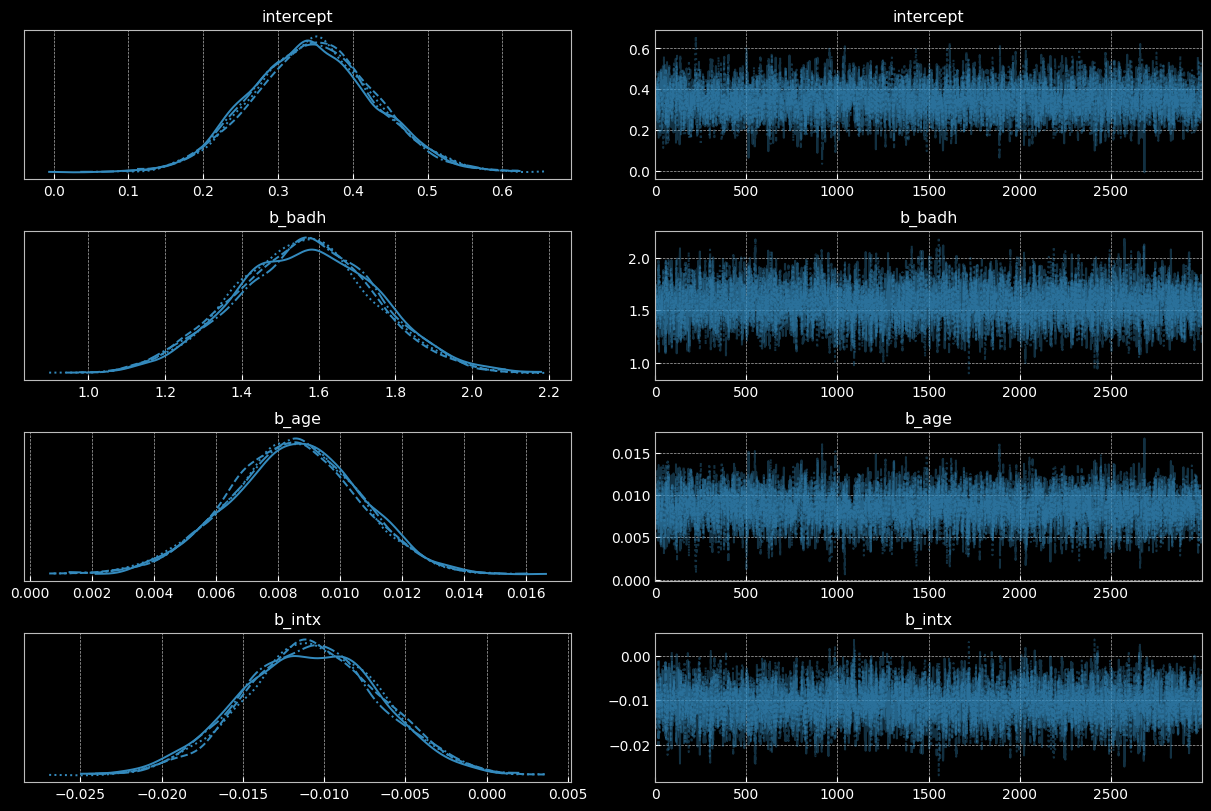

In [12]:
# Plotting posterior distribution of mu
az.plot_trace(trace)
plt.show()

In [13]:
pm.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,0.347,0.081,0.199,0.501,0.001,0.001,3466.0,3388.0,3474.0,4383.0,1.0
b_badh,1.563,0.181,1.221,1.902,0.003,0.002,3564.0,3564.0,3566.0,4646.0,1.0
b_age,0.008,0.002,0.005,0.012,0.000,0.000,3496.0,3496.0,3510.0,4373.0,1.0
b_intx,-0.011,0.004,-0.019,-0.003,0.000,0.000,3390.0,3390.0,3382.0,4686.0,1.0


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


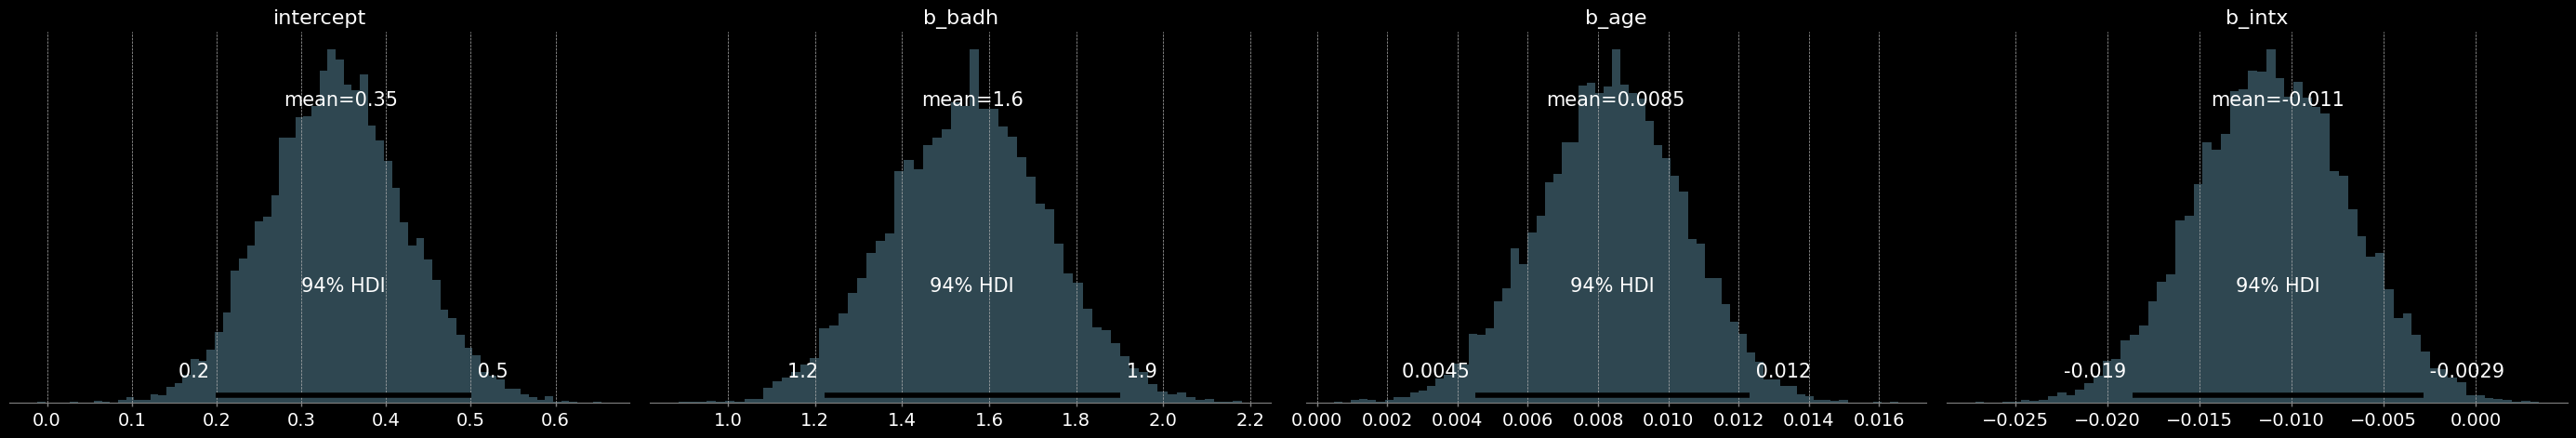

In [14]:
az.plot_posterior(trace, point_estimate = 'mean', kind = 'hist', color= "#87ceeb")
plt.show()

### Residuals

In [15]:
with lr:
    pm.set_data({'features': X})
    posterior = pm.sample_posterior_predictive(trace)

y_pred = posterior['likelihood']
print('The shape of the observations is: {}'.format(y_pred.shape))

The shape of the observations is: (12000, 1127)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


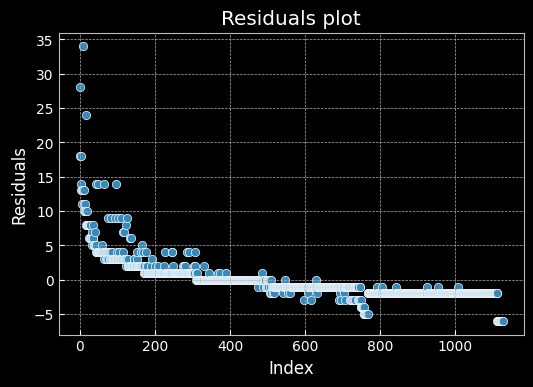

In [16]:
# Plotting the predictions
y_median = np.median(y_pred, axis=0).ravel()
y_std = y_pred.std(axis=0).ravel()
res = Y - y_median

# Plotting residuals
sns.scatterplot(np.arange(res.shape[0]), res, x="Index", y="Residuals")
plt.title('Residuals plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.show()

The index of the data seems to have something to do, with the value of the residual which would suggest that the data are not independent. It turns out in this case that the data were presorted. They were ordered by the number of doctor visits.
And so, we won't worry about this plot. 


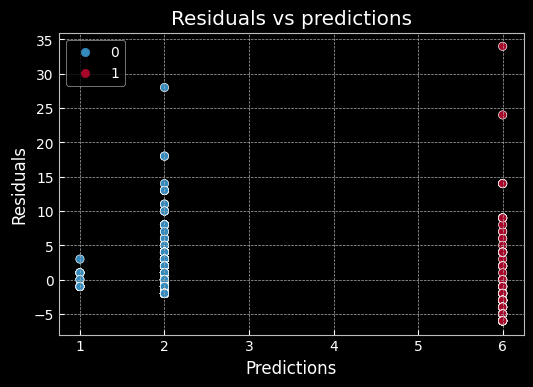

In [17]:
# Plotting infant vs income
sns.scatterplot(x = y_median.reshape(-1), y = res, hue = X[:, 0])
plt.title('Residuals vs predictions')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.show()

Interestingly, the model separated the predicted number of visits according to whether or not the person had bad health.
If the person had bad health, the model predicts they'll have about six visits. And if they don't have bad health the model predicts about two visits. 

It is not surprising that the variability increases for values predicted at higher values since the mean is also the variance in the Poisson distribution. However, observations predicted to have about two visits should have variance about two, and observations predicted to have about six visits should have variance about six.

In [18]:
print('The variance of the residuals with Bad health = 0 is : {}'.format(np.var(res[X[:, 0] == 0])))
print('The variance of the residuals with Bad health = 1 is : {}'.format(np.var(res[X[:, 0] == 1])))

The variance of the residuals with Bad health = 0 is : 7.04101919483608
The variance of the residuals with Bad health = 1 is : 40.852598852040806


This indicates that either the model fits poorly (meaning the covariates don’t explain enough of the variability in the data), or the data are “overdispersed” for the Poisson likelihood we have chosen. This is a common issue with count data. If the data are more variable than the Poisson likelihood would suggest, a good alternative is the negative binomial distribution.

### Predictive distributions

In [19]:
pm.summary(trace)

/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
intercept,0.347,0.081,0.199,0.501,0.001,0.001,3466.0,3388.0,3474.0,4383.0,1.0
b_badh,1.563,0.181,1.221,1.902,0.003,0.002,3564.0,3564.0,3566.0,4646.0,1.0
b_age,0.008,0.002,0.005,0.012,0.000,0.000,3496.0,3496.0,3510.0,4373.0,1.0
b_intx,-0.011,0.004,-0.019,-0.003,0.000,0.000,3390.0,3390.0,3382.0,4686.0,1.0


The intercept is not necessarily interpretable here because it corresponds to a healthy 0-year-old, whereas the youngest person in the data set is 20 years old.

For healthy individuals, it appears that age has a positive association with number of doctor visits. Clearly, bad health is associated with an increase in expected number of visits. The interaction coefficient is interpreted as an adjustment to the age coefficient for people in bad health. Hence, for people with bad health, age is essentially unassociated with number of visits.

Let’s say we have two people aged 35, one in good health and the other in poor health. What is the posterior probability that the individual with poor health will have more doctor visits? This goes beyond the posterior probabilities we have calculated comparing expected responses in previous lessons. Here we will create Monte Carlo samples for the responses themselves. This is done by taking the Monte Carlo samples of the model parameters, and for each of those, drawing a sample from the likelihood. Let’s walk through this.

In [20]:
X_test = np.array([[0, 35], [1, 35]])
print('The vector of new data is: \n{}'.format(X_test))

The vector of new data is: 
[[ 0 35]
 [ 1 35]]


In [21]:
# Sampling from posterior distribution
with lr:
    pm.set_data({'features': X_test})
    posterior_test = pm.sample_posterior_predictive(trace)

y_test = posterior_test['likelihood']
print('The shape of the observations is: {}'.format(y_test.shape))
# There are 12000 samples from each example (2)

The shape of the observations is: (12000, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


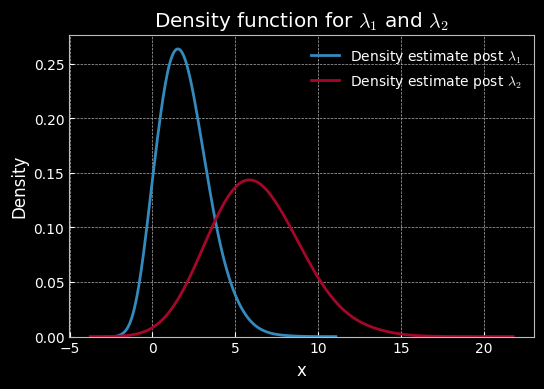

In [22]:
# Plotting the posterior density
fig, ax = plt.subplots(1, 1)
# plot density estimate of the posterior
sns.kdeplot(y_test[:, 0], bw=0.5, label = 'Density estimate post $\lambda_1$')
sns.kdeplot(y_test[:, 1], bw=0.5, label = 'Density estimate post $\lambda_2$')
# Approximation true posterior
ax.legend(loc='upper right', frameon=False)
plt.xlabel('x')
plt.title('Density function for $\lambda_1$ and $\lambda_2$')
plt.show()

Finally, we can answer the original question: What is the probability that the person with poor health will have more doctor visits than the person with good health?

In [23]:
ind = np.mean(y_test[:, 1] > y_test[:, 0])
print('The probability that a person with bad health has more visits is: {}'.format(ind))

The probability that a person with bad health has more visits is: 0.9161666666666667


Because we used our posterior samples for the model parameters in our simulation, this posterior predictive distribution on the number of visits for these two new individuals naturally takes into account our uncertainty in the model estimates. This is a more honest/realistic distribution than we would get if we had fixed the model parameters at their MLE or posterior means and simulated data for the new individuals.